In [1]:
%run imports.ipynb

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rc('font', family='FreeSans', size=7)

In [7]:
stability_data = pd.read_csv('source_data/stability_scores.csv')
instable_positions = set(stability_data[stability_data['stability_ratio_normalized_to_WT'] < 0.75]['aa_position'].values)

def is_ins(pos):
    return pos in instable_positions

In [9]:
import re

def classify_DNMT3A_mutation(hgvsp):
    if pd.isnull(hgvsp) or hgvsp == 'No data obtained':
        return 'WT'
    
#     if hgvsp == 'L773fs (L773-e18+5)' or hgvsp == 'R792H/R803fs(e21+2)' or hgvsp == 'R729Q/D618fs(e15+2)' or hgvsp == 'G590fs/ 1.5Mb deletion':
    if hgvsp == 'R792H/R803fs(e21+2)' or hgvsp == 'R729Q/D618fs(e15+2)' or hgvsp == 'A741V/E477*' or hgvsp == 'K829R/K468R':
        return 'Other'
    elif hgvsp == 'L773fs (L773-e18+5)':
        return 'INS'
    
    if re.search('([0-9]+)', hgvsp) is None:
        return 'WT'

    pos = int(re.search('([0-9]+)', hgvsp).group(0))
    
    if 'fs' in hgvsp or '*' in hgvsp:
        return 'INS'

    else:
        if re.search('([0-9]+)', hgvsp) is None:
            return 'WT'
        
        pos = int(re.search('([0-9]+)', hgvsp).group(0))

        if pos == 882:
            return 'R882'
        elif is_ins(pos):
            return 'INS'
        else:
            return 'Other'

## Timothy 2010

In [10]:
timothy2010 = pd.read_csv('../note2/results/CLINICAL-FINAL/timothy2010_clinical.csv')

columns = ['patient_id', 'age', 'gender', 'race', 'fab', 'cytogenetics', 'mll_status', 'percent_bm_blasts', 'pb_wbc_presentation', 'pb_blast', 'deceased', 
           'efs_months', 'os_months', 'DNMT3A', 'DNMT3A_consequence', 'FLT3_ITD', 'FLT3_other', 'IDH1', 'IDH2', 'NPM1']

timothy2010.columns = columns
timothy2010.head(3)

timothy2010['cohort'] = 'Timothy2010'

timothy2010['DNMT3A_status'] = timothy2010.DNMT3A.apply(classify_DNMT3A_mutation)

timothy2010 = timothy2010[['cohort', 'patient_id', 'age', 'gender', 'fab', 'cytogenetics', 'os_months', 'deceased', 'DNMT3A_status']]

timothy2010['deceased'] = timothy2010.deceased == 'Dead'
timothy2010['normal_cytogenetics'] = timothy2010.cytogenetics == 'normal'

In [11]:
timothy2010.DNMT3A_status.value_counts()

WT       220
R882      37
INS       18
Other      7
Name: DNMT3A_status, dtype: int64

## BEATAML

In [12]:
beataml = pd.read_csv('/data/project/SNUH_DNMT3A/note2/results/CLINICAL-FINAL/aml_ohsu_2018/data_clinical_patient.txt', sep='\t', skiprows=4)
beataml_sample = pd.read_csv('/data/project/SNUH_DNMT3A/note2/results/CLINICAL-FINAL/aml_ohsu_2018/data_clinical_sample.txt', sep='\t', skiprows=4)

# leukemia_samples = set(beataml_sample[beataml_sample.CANCER_TYPE == 'Leukemia'].SAMPLE_ID.unique())
leukemia_patients = set(beataml_sample[beataml_sample.CANCER_TYPE == 'Leukemia'].PATIENT_ID.unique())
denovo_patients = set(beataml_sample[(beataml_sample.SAMPLE_TIMEPOINT == 'Denovo') | (beataml_sample.SAMPLE_TIMEPOINT == 'Relapse')].PATIENT_ID.unique())
# denovo_patients = set(beataml_sample[(beataml_sample.SAMPLE_TIMEPOINT == 'Denovo')].PATIENT_ID.unique())

denovo_leukemia_patients = leukemia_patients & denovo_patients
# beataml = beataml[beataml.PATIENT_ID.isin(leukemia_patients)]
beataml = beataml[beataml.PATIENT_ID.isin(denovo_leukemia_patients)]

sample2patient = {r.SAMPLE_ID:r.PATIENT_ID for r in beataml_sample.to_records()}
patient2fab = {r.PATIENT_ID:r.FAB for r in beataml_sample.to_records()}
patient2cytogenetics = {r.PATIENT_ID:r.CYTOGENETICS_OTHER for r in beataml_sample.to_records()}

# beataml = beataml[beataml.CAUSE_OF_DEATH_SOURCE.notnull()]

beataml['cohort'] = 'BEATAML'
beataml['fab'] = beataml.PATIENT_ID.map(patient2fab)
beataml['cytogenetics'] = beataml.PATIENT_ID.map(patient2cytogenetics)

len(beataml)

306

In [14]:
from collections import defaultdict
patient2dnmt3aclass = defaultdict(lambda: 'WT')
patient2dnmt3a_mutation = {}

for patient in beataml.PATIENT_ID.unique():
    annotated_mutation = beataml_sample[beataml_sample.PATIENT_ID == patient]['DNMT3A_MUTATION'].values[0]
    patient2dnmt3a_mutation[patient] = annotated_mutation
    
    if pd.isnull(annotated_mutation) or annotated_mutation == 'Negative':
        patient2dnmt3aclass[patient] = 'WT'
    elif 'R882' in annotated_mutation or 'r882' in annotated_mutation:
        patient2dnmt3aclass[patient] = 'R882'
    elif annotated_mutation == 'p.P777S; MAF 90%':
        patient2dnmt3aclass[patient] = 'INS'
    elif annotated_mutation == 'c.2635_2651delAACATGAGCCGCTTGGC; p.N879Efs*36         c.2656C>T; pQ886*    MAF 43%, 36%':
        patient2dnmt3aclass[patient] = 'Other'
    elif annotated_mutation in {
        'p.R326P; MAF 50%',
        'F609fs*3; MAF 42%',
        'W297*; MAF 44%',
        'p.S307fs; MAF 45.6%',
        ' p.Trp297* (NM_175629.2); MAF 82.1%',
        'p.E283*; MAF 30%',
        'p.Gln231fs; MAF 33.2%',
        'F290fs*24; MAF 40%',
        'p.Arg326Cys; MAF 44.5%',
    }:
        patient2dnmt3aclass[patient] = 'INS'
    elif '*' in annotated_mutation or 'fs' in annotated_mutation:
        patient2dnmt3aclass[patient] = 'INS'
    elif annotated_mutation in {
        'p.P777L; MAF 50%',
        'p.R736H; MAF 45%',
        'p.S714C; MAF 35%',
    }:
        patient2dnmt3aclass[patient] = 'INS'
    else:
        patient2dnmt3aclass[patient] = 'Other'

In [15]:
beataml['DNMT3A_status'] = beataml.PATIENT_ID.map(patient2dnmt3aclass)
beataml['DNMT3A_mutation'] = beataml.PATIENT_ID.map(patient2dnmt3a_mutation)

beataml = beataml[['cohort', 'PATIENT_ID', 'AGE_AT_DIAGNOSIS', 'SEX', 'fab', 'cytogenetics', 'OS_MONTHS', 'OS_STATUS', 'DNMT3A_status', 'DNMT3A_mutation']]
beataml.columns = ['cohort', 'patient_id', 'age', 'gender', 'fab', 'cytogenetics', 'os_months', 'deceased', 'DNMT3A_status', 'DNMT3A_mutation']

beataml['deceased'] = beataml.deceased == '1:DECEASED'
beataml['normal_cytogenetics'] = beataml.cytogenetics == 'Normal'

## TCGA-LAML

In [16]:
tcga_patient = pd.read_csv('/data/project/SNUH_DNMT3A/note2/results/CLINICAL-FINAL/laml_tcga_pub/data_clinical_patient.txt', sep='\t', skiprows=4)
tcga_sample = pd.read_csv('/data/project/SNUH_DNMT3A/note2/results/CLINICAL-FINAL/laml_tcga_pub/data_clinical_sample.txt', sep='\t', skiprows=4)
tcga_mutations = pd.read_csv('/data/project/SNUH_DNMT3A/note2/results/CLINICAL-FINAL/laml_tcga_pub/data_mutations_extended.txt', sep='\t')

tcga_patient.head(3)

,PATIENT_ID,SEX,RACE,FAB,AGE,BM_BLAST_PERCENTAGE,WBC,PB_BLAST_PERCENTAGE,AML_IN_SKIN_PERCENTAGE,CYTOGENETICS,CYTOGENETIC_CODE_OTHER,RISK_CYTO,HISTOLOGICAL_SUBTYPE,RISK_MOLECULAR,DFS_MONTHS,DFS_STATUS,INDUCTION,TRANSPLANT_TYPE,DARK_ZONE_STAT,OS_MONTHS,OS_STATUS
0,TCGA-AB-2803,Female,WHITE,M3,61,44,1.0,NaN,n.d.,"46,XX,t(15;17)(q22:q21)[15]",PML-RARA,Good,PML-RARA,Good,24.1,1:Recurred/Progressed,7+3+ATRA,0,0,25.7,1:DECEASED
1,TCGA-AB-2804,Male,WHITE,M3,30,82,5.7,NaN,n.d.,"46, XY[25]",Normal Karyotype,Intermediate,PML-RARA,Good,57.2,1:Recurred/Progressed,7+3+ATRA,"Auto, sib Allo","CR 2, CR 3",95.3,0:LIVING
2,TCGA-AB-2806,Male,WHITE,M1,46,90,29.4,81.0,n.d.,"45,X,-Y, t(8;7;21)(q22;p15;q22[22]/46,XY[3]",RUNX1-RUNX1T1,Good,RUNX1-RUNX1T1,Good,16.1,1:Recurred/Progressed,7+3+3+PSC,MUD,CR 2,30.6,1:DECEASED


In [18]:
meta = pd.read_excel('source_data/variant_calls.xlsx', sheet_name='TCGA-LAML')
tcga_barcode2status = {r.Name:r['status'] for r in meta.to_records()}

In [19]:
tcga_patient['DNMT3A_status'] = tcga_patient.PATIENT_ID.map(tcga_barcode2status)

In [20]:
tcga_patient['cohort'] = 'TCGA-LAML'
tcga = tcga_patient[['cohort', 'PATIENT_ID', 'AGE', 'SEX', 'FAB', 'CYTOGENETIC_CODE_OTHER', 'OS_MONTHS', 'OS_STATUS', 'DNMT3A_status']].copy()

tcga.columns = ['cohort', 'patient_id', 'age', 'gender', 'fab', 'cytogenetics', 'os_months', 'deceased', 'DNMT3A_status']
tcga['deceased'] = tcga.deceased == '1:DECEASED'
tcga['normal_cytogenetics'] = tcga.cytogenetics == 'Normal Karyotype'

## Overall

In [21]:
data = pd.concat([timothy2010, beataml, tcga])

len(timothy2010), len(beataml), len(tcga)

(282, 306, 200)

In [22]:
import lifelines
from matplotlib.lines import Line2D

In [29]:
data_notnull = data[(data.deceased.notnull()) & (data.os_months.notnull())]
data_notnull = data_notnull[data_notnull.age >= 20]
data_notnull = data_notnull[data_notnull.fab != 'M3']

In [30]:
data_notnull.DNMT3A_status.value_counts()

WT       520
R882      85
INS       41
Other     22
Name: DNMT3A_status, dtype: int64

In [33]:
data_notnull.to_csv('source_data/survival.csv', index=False)

There are 668 patients in this survival analysis.
INS vs Other log-rank p: 0.45173435340582546


/data/project/dohoon/miniconda3/envs/dnmt3a/lib/python3.7/site-packages/lifelines/plotting.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


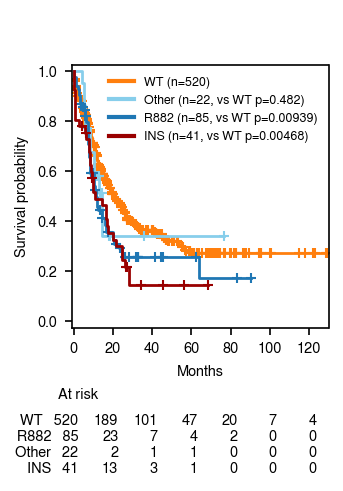

In [66]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(2.3, 2.3))

configs = [
    {'fab': False, 'cyto': False, 'title': 'Entire pooled cohort'},
    {'fab': True, 'cyto': False, 'title': 'Non-M3'},
    {'fab': False, 'cyto': True, 'title': 'CN-AML'},
    {'fab': True, 'cyto': True, 'title': 'Non-M3 CN-AML'},
]

ax = fig.add_subplot(111)

print(f'There are {len(data_notnull)} patients in this survival analysis.')

wt_mask = (data_notnull.DNMT3A_status == 'WT')
r882_mask = (data_notnull.DNMT3A_status == 'R882')
other_mask = (data_notnull.DNMT3A_status == 'Other')
ins_mask = (data_notnull.DNMT3A_status == 'INS')

labels = []
kmf_dict = {}

for label, color, mask in zip(['WT', 'Other', 'R882', 'INS'], ['C1', 'skyblue', 'C0', '#990000'], [wt_mask, other_mask, r882_mask, ins_mask]):
    E = (data_notnull[mask].deceased)
    T = (data_notnull[mask].os_months)

    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(T, E, label=label)
    kmf.plot_survival_function(ax=ax, show_censors=True, censor_styles={'ms': 5}, c=color, lw=1.33, ci_show=False)
    
    kmf_dict[label] = kmf

    if label == 'WT':
        labels.append(f'{label} (n={mask.sum()})')
    else:
        cox = lifelines.CoxPHFitter()

        tmp = data_notnull.copy()
        tmp['mut_status'] = mask
        tmp = tmp[mask | wt_mask]

        p = lifelines.statistics.logrank_test(
            durations_A = data_notnull[wt_mask].os_months,
            durations_B = data_notnull[mask].os_months,
            event_observed_A = (data_notnull[wt_mask].deceased),
            event_observed_B = (data_notnull[mask].deceased),
        ).summary.p.values[0]
        
        labels.append(f'{label} (n={mask.sum()}, vs WT p={p:.3g})')
        
p = lifelines.statistics.logrank_test(
    durations_A = data_notnull[ins_mask].os_months,
    durations_B = data_notnull[other_mask].os_months,
    event_observed_A = (data_notnull[ins_mask].deceased),
    event_observed_B = (data_notnull[other_mask].deceased),
).summary.p.values[0]
print(f'INS vs Other log-rank p: {p}')


handles = [
    Line2D([0], [0], color='C1', linewidth=2),
    Line2D([0], [0], color='skyblue', linewidth=2),
    Line2D([0], [0], color='C0', linewidth=2),
    Line2D([0], [0], color='#990000', linewidth=2),
]
ax.legend(handles, labels, frameon=False, fontsize=6)

ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_xticks(range(0, int(data_notnull.os_months.max()), 20))
ax.set_xlim([-1, int(data_notnull.os_months.max()) + 1])
ax.set_ylim([-0.025, 1.025])

from lifelines.plotting import add_at_risk_counts

ax = fig.add_axes((0.23, 0.3, 0.69, 0.8))
ax.set_xticks(range(0, int(data_notnull.os_months.max()), 20))
ax.axis('off')
ax2 = add_at_risk_counts(kmf_dict['WT'], kmf_dict['R882'], kmf_dict['Other'], kmf_dict['INS'], ax=ax)

save_figures('source_data_figures/survival/km_plot')

In [61]:
gender_binary_map = {
    'M': 0,
    'F': 1,
    'Male': 0,
    'Female': 1,
}

data_notnull = pd.read_csv('source_data/survival.csv')
data_notnull['gender_binary'] = data_notnull.gender.map(gender_binary_map)

In [68]:
t = data_notnull.copy()

cols = pd.get_dummies(data_notnull.DNMT3A_status).columns
t[cols] = pd.get_dummies(data_notnull.DNMT3A_status)

# t[['M0', 'M1', 'M2', 'M4', 'M4eo', 'M5', 'M5a', 'M5b', 'M6', 'M7', 'NOS', 'nc']] = pd.get_dummies(data_notnull.fab)
t['fab_m3'] = t.fab == 'M3'

t = t[~t.fab_m3]
t = t[t.age >= 20]
t['age_bin'] = (t.age > 60).astype(int)
t = t[['Other', 'R882', 'INS', 'age_bin', 'gender_binary', 'os_months', 'deceased']].dropna()

cox = lifelines.CoxPHFitter()

cox.fit(df=t.reset_index(drop=True), duration_col='os_months', event_col='deceased')

<lifelines.CoxPHFitter: fitted with 668 observations, 271 censored>

In [69]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 668 observations, 271 censored>
      duration col = 'os_months'
         event col = 'deceased'
number of subjects = 668
  number of events = 397
    log-likelihood = -2275.47
  time fit was run = 2022-11-11 00:09:26 UTC

---
               coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
Other         -0.14       0.87      0.30 -0.48   0.63      0.66       -0.73        0.44
R882           0.47       1.59      0.15  3.20 <0.005      9.53        0.18        0.75
INS            0.61       1.85      0.19  3.27 <0.005      9.86        0.25        0.98
age_bin        1.01       2.74      0.11  9.60 <0.005     70.07        0.80        1.21
gender_binary  0.01       1.01      0.10  0.14   0.89      0.17       -0.19        0.22
---
Concordance = 0.65
Log-likelihood ratio test = 101.46 on 5 df, -log2(p)=65.06


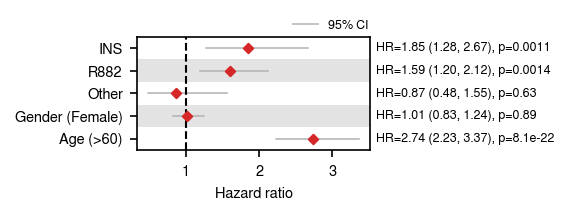

In [70]:
res = cox.summary.loc[['INS', 'R882', 'Other', 'gender_binary', 'age_bin']]

res['lower 0.95'] = np.exp(res['lower 0.95'])
res['upper 0.95'] = np.exp(res['upper 0.95'])

fig = plt.figure(figsize=(2, 1))
ax = fig.add_subplot(111)

for i, r in enumerate(res.to_records()):
    if i == 0:
        ax.plot([r['lower 0.95'], r['upper 0.95']], [i, i], c='0.7', label='95% CI')
    else:
        ax.plot([r['lower 0.95'], r['upper 0.95']], [i, i], c='0.7')
    ax.scatter(r['exp(coef)'], i, marker='D', c='C3', s=10, zorder=10)
    
    annotation_x = 3.6
    ax.annotate(f'HR={r["exp(coef)"]:.2f} ({r["lower 0.95"]:.2f}, {r["upper 0.95"]:.2f}), p={r["p"]:.2g}', (annotation_x, i), (annotation_x, i),
                    annotation_clip=False, ha='left', va='center', fontsize=6)

ax.legend(frameon=False, bbox_to_anchor=(1.04, 1.25), loc='upper right', fontsize=6)    

ax.axhspan(0.5, 1.5, fc='k', alpha=0.11)
ax.axhspan(2.5, 3.5, fc='k', alpha=0.11)

ax.set_xlabel('Hazard ratio')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['INS', 'R882', 'Other', 'Gender (Female)', 'Age (>60)'])

ax.axvline(1.0, ls='--', lw=1, c='k')    
ax.set_ylim([-0.5, 4.5])
# ax.set_xscale('log')
ax.invert_yaxis()

save_figures('source_data_figures/survival/cox_plot')